In [1]:
# For Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
# os.chdir('/content/drive/My Drive/colab_data/TPS2205/input')

In [3]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # its for debug

In [4]:
%%capture
!pip install wandb
!pip install pytorch_lightning

In [5]:
%%capture
!pip install pytorch-tabnet

# DataSet & Library Loading

In [6]:
# common
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import time, gc, string, math
from tqdm import tqdm
import warnings
import shutil

# sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# pytorch
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch import optim
from torch.optim import lr_scheduler

# pytorch lightning
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

# LGBM
from lightgbm import LGBMClassifier
import lightgbm as lgb

# XGBoost
from xgboost import XGBClassifier

# TabNet
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier

In [7]:
import wandb

try:
    # add-ons -> secrets -> set your wandb api key
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb_api")
    wandb.login(key=secret_value_0)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
warnings.filterwarnings('ignore')

In [9]:
os.makedirs('model', exist_ok=True)
shutil.rmtree('./model/')

In [10]:
os.makedirs('model', exist_ok=True)

In [11]:
device = device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [12]:
class CFG:
    # あまりかえないやつら
    label = 'target'  # 目標変数
    seed=42
    print_batch_freq=100  # TODO 未実装
    print_epoch_freq = 5
    num_workers=2   # 1以外だと、なんかエラーが大量に出るかも。tqdmの問題っぽい
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # デバッグ時に変えるやつら
    debug = False
    n_fold = 5  # 5
    trn_fold = [0,1,2,3,4]  # [0,1,2,3,4,5,6,7,8,9], [0,1,2,3,4]
    epochs = 300  # 300
    small_data = False  # True, False
    n_estimators = 10_00  # LGBM用 10_000
    # モデルに影響するやつら
    batch_size = 2_048  # バッチサイズ
    virtual_batch_size = 128  # TabNet用
    lr=1e-2
    lr_min=1e-4
    lr_gamma=0.9
    num_emb=32
    scheduler_type = "ReduceLR"
    weight_decay = 1e-5  # 大きいほど使う特徴量が少ないモデルになる

In [13]:
if CFG.debug:
    CFG.n_fold = 2  # 5
    CFG.trn_fold = [0]  # [0,1,2,3,4,5,6,7,8,9], [0,1,2,3,4]
    CFG.epochs = 1  # 300
    CFG.small_data = True  # True, False
    CFG.n_estimators = 1  # LGBM用 10_000

In [14]:
pl.utilities.seed.seed_everything(seed=CFG.seed)

42

## FE

In [15]:
# データセット読み込み
train = pd.read_csv("../input/tabular-playground-series-may-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-may-2022/test.csv")
sub = pd.read_csv("../input/tabular-playground-series-may-2022/sample_submission.csv")
test[CFG.label]=0
if CFG.small_data:
    train = train[:10000]
    test = test[:10000]

In [16]:
df_all = pd.concat([train, test])

In [17]:
df_all['i_02_21'] = (df_all.f_21 + df_all.f_02 > 5.2).astype(int) - (df_all.f_21 + df_all.f_02 < -5.3).astype(int) + 1
df_all['i_05_22'] = (df_all.f_22 + df_all.f_05 > 5.1).astype(int) - (df_all.f_22 + df_all.f_05 < -5.4).astype(int) + 1
i_00_01_26 = df_all.f_00 + df_all.f_01 + df_all.f_26
df_all['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)+1

In [18]:
# NA埋め
# df_all.fillna(df_all.mean(numeric_only=True), inplace=True)

In [19]:
df_all["unique_characters"] = df_all.f_27.apply(lambda s: len(set(s)))

In [20]:
# f_27を分解
def splitter(text):
    arr = tuple(text)
    return arr

column_list = ['f_27_' + str(i) for i in range(10)]
df_all[column_list] = df_all.apply(lambda x: splitter(x['f_27']), axis=1, result_type='expand')
lstm_features = column_list[:]

In [21]:
# f_27_0~9を数値に
for column in column_list:
    df_all[column] = df_all[column].apply(lambda x: ord(x)-ord('A'))

In [22]:
# f_27_0~9の各種統計量を求める
df_all['f_27_mean'] =  df_all[column_list].mean(axis=1)
df_all['f_27_std'] =  df_all[column_list].std(axis=1)
df_all['f_27_sm'] = df_all['f_27_std'] / (df_all['f_27_mean']+0.001)

In [23]:
# f_27に出てくる文字が、何種類あるかを返す
def calc_cnt_of(txt):
    cnt_of = Counter(list(txt))
    return len(cnt_of)

df_all['len_cnt_of'] = df_all['f_27'].apply(calc_cnt_of)

In [24]:
# f_27に各文字が何回出てくるかを数える
def calc_char_cnt(txt):
    cnt_of = Counter(list(txt))
    ret = []
    for c in string.ascii_uppercase:
        ret.append(float(cnt_of[c]))
    return tuple(ret)


column_list = []
for c in string.ascii_uppercase:
    column_list.append('f_27_cnt_' + c)

df_all[column_list] = df_all.apply(lambda x: calc_char_cnt(x['f_27']), axis=1, result_type='expand')

In [25]:
# 不要になったカテゴリ変数を削除
df_all.drop(['f_27'], axis=1, inplace=True)

In [26]:
for i,j in [(26, 21), (26, 22), (21, 22), (26, 30), (26, 25),
            (22, 30), (22, 25), (21, 30), (21, 25), (30, 25)]:
    df_all['f_{}_plus_f_{}'.format(i, j)] = df_all['f_{}'.format(i)] + df_all['f_{}'.format(j)]
    df_all['f_{}_minus_f_{}'.format(i, j)] = df_all['f_{}'.format(i)] - df_all['f_{}'.format(j)]

In [27]:
# 明らかに要らない列を削除する
del_list = []
for column in df_all.columns:
    if df_all[column].nunique() == 1:
        print(column)
        del_list.append(column)
df_all.drop(del_list, axis=1, inplace=True)

f_27_cnt_U
f_27_cnt_V
f_27_cnt_W
f_27_cnt_X
f_27_cnt_Y
f_27_cnt_Z


In [28]:
features = []
cat_features = []

In [29]:
#@title
for column in df_all.columns:
    if column in ['id', CFG.label]:
        continue
    if df_all[column].dtype == 'int64' and df_all[column].nunique() < CFG.num_emb:
        features.append(column)
        cat_features.append(column)
    else:
        features.append(column)

In [30]:
train = df_all[:len(train)]
test = df_all[len(train):]

In [31]:
# Scaling test and train
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

In [32]:
train.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22_plus_f_30,f_22_minus_f_30,f_22_plus_f_25,f_22_minus_f_25,f_21_plus_f_30,f_21_minus_f_30,f_21_plus_f_25,f_21_minus_f_25,f_30_plus_f_25,f_30_minus_f_25
0,0,-1.374490,0.237914,-0.244425,0.568674,-0.647037,0.839148,0.113849,-0.622798,1.849207,...,-1.254121,-0.657097,-0.790125,-0.676355,0.887198,1.542933,0.853300,0.997172,-0.516487,-0.256376
1,1,1.699197,-1.712872,-2.230360,-0.544198,1.113558,-1.552654,0.448561,-0.622798,0.592099,...,0.455973,1.414176,-0.452789,1.967978,0.534479,1.221180,-0.489461,1.743624,-1.847004,1.226471
2,2,1.683885,0.616078,-1.028335,0.811719,-0.608415,0.113695,-0.707992,-0.622798,-1.293562,...,-0.134548,-1.020301,0.334747,-1.256619,0.148154,-0.594591,0.598206,-0.897538,1.343664,-0.669909
3,3,-0.118017,-0.589476,-0.805398,2.087827,0.371515,-0.129132,-0.281882,0.584807,-0.036455,...,-0.149321,0.681042,-0.576509,1.037029,-1.279412,-0.433469,-1.476525,0.144644,-1.381997,0.708225
4,4,1.150047,-0.177876,-0.665703,-1.099783,0.468368,0.499896,0.408249,0.584807,0.592099,...,-1.386197,-1.676685,-2.001461,-0.132427,0.516277,0.472895,-0.661312,1.322325,-1.297746,1.444121


In [33]:
test.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22_plus_f_30,f_22_minus_f_30,f_22_plus_f_25,f_22_minus_f_25,f_21_plus_f_30,f_21_minus_f_30,f_21_plus_f_25,f_21_minus_f_25,f_30_plus_f_25,f_30_minus_f_25
0,900000,0.443296,0.173355,-1.000476,0.763976,0.187318,-1.075194,0.502626,2.396213,2.477760,...,-0.776173,-0.078204,-0.901713,0.302090,-0.743042,0.055813,-0.902568,0.358288,-1.171211,0.473306
1,900001,-0.605986,-0.307128,0.626171,-0.577429,-1.750070,1.355436,-0.190213,-0.622798,0.592099,...,-0.299481,0.499167,-0.201308,0.334097,0.616034,1.295575,0.493569,0.953081,-0.708945,-0.041884
2,900002,0.304615,2.445921,0.245214,0.819474,0.360241,-1.332297,1.359411,0.584807,0.592099,...,0.468025,0.569155,0.468742,0.287672,-2.756186,-2.512277,-1.948126,-2.016265,0.151080,-0.170580
3,900003,0.154511,0.259170,-1.367563,-0.091791,-1.110279,-0.948885,1.119995,-1.226600,-1.293562,...,-1.750479,-1.258286,-1.384543,-0.866524,-0.577863,0.206491,-0.487866,0.205454,-0.812499,0.073526
4,900004,-1.653458,-0.425775,-0.668187,-0.320700,-0.088877,0.181443,1.785797,-0.018996,-0.036455,...,0.007410,-0.848360,0.015627,-0.633463,0.496722,-0.276624,0.384526,-0.219660,0.756271,-0.015265


## CV

In [34]:
# CV Split
skf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(skf.split(train, train[CFG.label])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    180000
1    180000
2    180000
3    180000
4    180000
dtype: int64

## TabNet

In [35]:
cat_idxs = []
cat_dims = []
"""
cat_idxs = [-1]*len(cat_features)
cat_dims = [128]*len(cat_features)
for i, cat_f in enumerate(cat_features):
    idx = features.index(cat_f)
    cat_idxs[i] = idx
    cat_dims[i] = df_all[cat_f].nunique()+1
"""

'\ncat_idxs = [-1]*len(cat_features)\ncat_dims = [128]*len(cat_features)\nfor i, cat_f in enumerate(cat_features):\n    idx = features.index(cat_f)\n    cat_idxs[i] = idx\n    cat_dims[i] = df_all[cat_f].nunique()+1\n'

In [36]:
"""
predictions = pd.DataFrame()
for fold in CFG.trn_fold:
    print("="*10, fold, "="*10)
    train_folds = train[train['fold']!=fold]
    valid_folds = train[train['fold']==fold]
    X_train = train_folds[features].to_numpy()
    y_train = train_folds[CFG.label].to_numpy()
    X_valid = valid_folds[features].to_numpy()
    y_valid = valid_folds[CFG.label].to_numpy()
    X_test = test[features].to_numpy()

    tabnet_params = dict(
        # TODO ここら辺初期値にしてみる
        n_d=64,  # Width of the decision prediction layer. Bigger values gives more capacity to the model with the risk of overfitting. Values typically range from 8 to 64.
        n_a=64,  # Width of the attention embedding for each mask. According to the paper n_d=n_a is usually a good choice. (default=8)
        n_steps=5,  # Number of steps in the architecture (usually between 3 and 10)
        gamma=1.3,  # This is the coefficient for feature reusage in the masks. A value close to 1 will make mask selection least correlated between layers. Values range from 1.0 to 2.0.
        cat_idxs=cat_idxs, # list of int (default=[] - Mandatory for embeddings). List of categorical features indices.
        cat_dims=cat_dims,  # list of int (default=[] - Mandatory for embeddings). List of categorical features number of modalities (number of unique values for a categorical feature) /!\ no new modalities can be predicted
        cat_emb_dim=2,  # list of int (optional). List of embeddings size for each categorical features. (default =1)
        n_independent=3,  # Number of independent Gated Linear Units layers at each step. Usual values range from 1 to 5.
        n_shared=3,  # Number of shared Gated Linear Units at each step Usual values range from 1 to 5.
        # epsilon=1e-15   # Should be left untouched.
        seed=CFG.seed,
        momentum=0.01,  # Momentum for batch normalization, typically ranges from 0.01 to 0.4 (default=0.02)
        clip_value=None,  # float (default None). If a float is given this will clip the gradient at clip_value.
        lambda_sparse=1e-6,  # float (default = 1e-3). This is the extra sparsity loss coefficient as proposed in the original paper. The bigger this coefficient is, the sparser your model will be in terms of feature selection. Depending on the difficulty of your problem, reducing this value could help.

        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(
            lr=CFG.lr,
            weight_decay=1e-7
        ),
        scheduler_fn=lr_scheduler.ReduceLROnPlateau,
        scheduler_params=dict(
            mode='max',
            factor=0.5,
            patience=3,
            min_lr=CFG.lr_min,
        ),

        verbose=1,  # Verbosity for notebooks plots, set to 1 to see every epoch, 0 to get None.
        device_name='auto',  #  str (default='auto') 'cpu' for cpu training, 'gpu' for gpu training, 'auto' to automatically detect gpu
        mask_type='sparsemax',  # (default='sparsemax') Either "sparsemax" or "entmax" : this is the masking function to use for selecting features.
    )

    print('unsupervised_model')
    unsupervised_model = TabNetPretrainer(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=2,
        optimizer_fn=torch.optim.Adam,
        device_name='auto',  #  str (default='auto') 'cpu' for cpu training, 'gpu' for gpu training, 'auto' to automatically detect gpu
        seed=CFG.seed,
    )

    unsupervised_model.fit(
        X_train=X_train,
        eval_set=[X_valid],
        pretraining_ratio=0.8,
        batch_size=CFG.batch_size,
        virtual_batch_size=CFG.virtual_batch_size,  # 小さいとよいらしい
        patience=10,
        max_epochs=CFG.epochs,
        pin_memory=True,
        num_workers=2,
    )

    print('main model')
    # Defining TabNet model
    model = TabNetClassifier(**tabnet_params)
    model.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=["train", "valid"],
        eval_metric=["auc"],
        batch_size=CFG.batch_size,
        virtual_batch_size=CFG.virtual_batch_size,  # 小さいとよいらしい
        max_epochs=CFG.epochs,
        drop_last=True,
        pin_memory=True,
        patience=10,
        num_workers=2,
        from_unsupervised=unsupervised_model,
        # weights=1,  # サンプリングするか否かっポイ default:0  # TODO weights=0の時との挙動の違いを見たい
    )

    model.save_model("./model/{}_fold_{}".format("stack9", fold))

    y_pred = model.predict_proba(X_valid)[:, 1]

    auc = roc_auc_score(y_valid, y_pred)
    print("auc: ", auc)
    train.loc[train['fold']==fold, 'stack9'] = y_pred

    # y_pred = model.predict_proba(X_test)[:, 1]
    # predictions = pd.concat([predictions, pd.DataFrame(y_pred)], axis=1)
    del model
    gc.collect()
"""

'\npredictions = pd.DataFrame()\nfor fold in CFG.trn_fold:\n    print("="*10, fold, "="*10)\n    train_folds = train[train[\'fold\']!=fold]\n    valid_folds = train[train[\'fold\']==fold]\n    X_train = train_folds[features].to_numpy()\n    y_train = train_folds[CFG.label].to_numpy()\n    X_valid = valid_folds[features].to_numpy()\n    y_valid = valid_folds[CFG.label].to_numpy()\n    X_test = test[features].to_numpy()\n\n    tabnet_params = dict(\n        # TODO ここら辺初期値にしてみる\n        n_d=64,  # Width of the decision prediction layer. Bigger values gives more capacity to the model with the risk of overfitting. Values typically range from 8 to 64.\n        n_a=64,  # Width of the attention embedding for each mask. According to the paper n_d=n_a is usually a good choice. (default=8)\n        n_steps=5,  # Number of steps in the architecture (usually between 3 and 10)\n        gamma=1.3,  # This is the coefficient for feature reusage in the masks. A value close to 1 will make mask selectio

## predict

In [37]:
"""
import glob

models = np.sort(glob.glob(f"../input/model/stack9*"))
print(models)
predictions = pd.DataFrame()

for model_path in models:
    X_test = test[features].to_numpy()
    model = TabNetClassifier()
    model.load_model(model_path)

    y_pred = model.predict_proba(X_test)[:, 1]
    predictions = pd.concat([predictions, pd.DataFrame(y_pred)], axis=1)
test['stack9'] = predictions.mean(axis=1)
"""

'\nimport glob\n\nmodels = np.sort(glob.glob(f"../input/model/stack9*"))\nprint(models)\npredictions = pd.DataFrame()\n\nfor model_path in models:\n    X_test = test[features].to_numpy()\n    model = TabNetClassifier()\n    model.load_model(model_path)\n\n    y_pred = model.predict_proba(X_test)[:, 1]\n    predictions = pd.concat([predictions, pd.DataFrame(y_pred)], axis=1)\ntest[\'stack9\'] = predictions.mean(axis=1)\n'

In [38]:
train.to_pickle("train.pkl")
test.to_pickle("test.pkl")

In [39]:
train = pd.read_pickle("train.pkl")
test = pd.read_pickle("test.pkl")

# Pytorch

## DataSet and DataLoader

In [40]:
class TrainDataset(Dataset):
    def __init__(self, X_train, y_train):
        self.X = X_train
        self.y = y_train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        inputs = torch.tensor(self.X[item], dtype=torch.float32)
        labels = torch.tensor(self.y[item], dtype=torch.float32)

        return inputs, labels

In [41]:
class TestDataset(Dataset):
    def __init__(self, X_train):
        self.X = X_train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        inputs = torch.tensor(self.X[item], dtype=torch.float32)

        return inputs

In [42]:
class MyDataModule(pl.LightningDataModule):
    # train, val, testの3つのDataLoaderを定義する
    # trainerにこれを渡すと、train, val, testのそれぞれのステップでこれを渡してくれる
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame = None, fold: int=0, features: list=[], target: str="", batch_size: int = 10_000):
        """
        train_df: trainとvalid用のデータフレーム
        test_df: prediction用のデータフレーム 空の場合はvalid用の値を入れる
        fold: CV用のfold
        features: 学習対象のカラム名
        target: 目標変数
        batch_size: ミニバッチ法のバッチサイズ
        """
        train_folds = train_df[train_df['fold'] != fold]
        valid_folds = train_df[train_df['fold'] == fold]
        self.X_train = train_folds[features].values
        self.X_valid = valid_folds[features].values
        self.y_train = train_folds[target].values
        self.y_valid = valid_folds[target].values
        if test_df is not None:
            self.X_test = test_df[features].values
        else:
            self.X_test = self.X_valid  # 変更は加えないので参照でよい
        self.batch_size = batch_size
        self._log_hyperparams = None  # ナニコレ・・・

    def train_dataloader(self):
        ds = TrainDataset(self.X_train, self.y_train)
        dl = DataLoader(ds, batch_size=self.batch_size, shuffle=True, pin_memory=True, drop_last=True, num_workers=CFG.num_workers, persistent_workers=True)
        return dl

    def val_dataloader(self):
        ds = TrainDataset(self.X_valid, self.y_valid)
        dl = DataLoader(ds, batch_size=self.batch_size, shuffle=False, pin_memory=True, drop_last=True, num_workers=CFG.num_workers, persistent_workers=True)
        return dl

    def predict_dataloader(self):
        ds = TestDataset(self.X_test)
        dl = DataLoader(ds, batch_size=self.batch_size, shuffle=False, pin_memory=True, drop_last=True, num_workers=CFG.num_workers, persistent_workers=True)
        return dl

    def prepare_data_per_node(self):
        # TODO 本来要らないはずなんだけど・・・
        pass

    def teardown(self, stage=None):
        self.X_train = None
        self.X_valid = None
        self.y_train = None
        self.y_valid = None
        self.X_test = None
        torch.cuda.empty_cache()  # TODO: これであってるのか不明　何も出てこないんだよね
        gc.collect()

In [43]:
class LSTMTrainDataset(Dataset):
    def __init__(self, X_train, X_LSTM_train, y_train):
        self.X = X_train
        self.X_LSTM = X_LSTM_train
        self.y = y_train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        inputs = torch.tensor(self.X[item], dtype=torch.float32)
        lstm_inputs = torch.tensor(self.X_LSTM[item], dtype=torch.float32)
        labels = torch.tensor(self.y[item], dtype=torch.float32)

        return (inputs, lstm_inputs), labels

In [44]:
class LSTMTestDataset(Dataset):
    def __init__(self, X_train, X_LSTM_train):
        self.X = X_train
        self.X_LSTM = X_LSTM_train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        inputs = torch.tensor(self.X[item], dtype=torch.float32)
        lstm_inputs = torch.tensor(self.X_LSTM[item], dtype=torch.float32)

        return (inputs, lstm_inputs)

In [45]:
class LSTMDataModule(pl.LightningDataModule):
    # train, val, testの3つのDataLoaderを定義する
    # trainerにこれを渡すと、train, val, testのそれぞれのステップでこれを渡してくれる
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame = None, fold: int=0, features: list=[], target: str="", batch_size: int = 10_000):
        """
        train_df: trainとvalid用のデータフレーム
        test_df: prediction用のデータフレーム 空の場合はvalid用の値を入れる
        fold: CV用のfold
        features: 学習対象のカラム名
        target: 目標変数
        batch_size: ミニバッチ法のバッチサイズ
        """
        train_folds = train_df[train_df['fold'] != fold]
        valid_folds = train_df[train_df['fold'] == fold]
        self.X_train = train_folds[features].values
        self.X_valid = valid_folds[features].values
        self.X_LSTM_train = train_folds[lstm_features].values
        self.X_LSTM_train = self.X_LSTM_train.reshape(self.X_LSTM_train.shape[0], -1, 1)
        self.X_LSTM_valid = valid_folds[lstm_features].values
        self.X_LSTM_valid = self.X_LSTM_valid.reshape(self.X_LSTM_valid.shape[0], -1, 1)
        self.y_train = train_folds[target].values
        self.y_valid = valid_folds[target].values
        if test_df is not None:
            self.X_test = test_df[features].values
            self.X_LSTM_test = test_df[lstm_features].values
            self.X_LSTM_test = self.X_LSTM_test.reshape(self.X_LSTM_test.shape[0], -1, 1)
        else:
            self.X_test = self.X_valid  # 変更は加えないので参照でよい
            self.X_LSTM_test = self.X_LSTM_valid
        self.batch_size = batch_size
        self._log_hyperparams = None  # ナニコレ・・・

    def train_dataloader(self):
        ds = LSTMTrainDataset(self.X_train, self.X_LSTM_train, self.y_train)
        dl = DataLoader(ds, batch_size=self.batch_size, shuffle=True, pin_memory=True, drop_last=True, num_workers=CFG.num_workers, persistent_workers=True)
        return dl

    def val_dataloader(self):
        ds = LSTMTrainDataset(self.X_valid, self.X_LSTM_valid, self.y_valid)
        dl = DataLoader(ds, batch_size=self.batch_size, shuffle=False, pin_memory=True, drop_last=True, num_workers=CFG.num_workers, persistent_workers=True)
        return dl

    def predict_dataloader(self):
        ds = LSTMTestDataset(self.X_test, self.X_LSTM_test)
        dl = DataLoader(ds, batch_size=self.batch_size, shuffle=False, pin_memory=True, drop_last=True, num_workers=CFG.num_workers, persistent_workers=True)
        return dl

    def prepare_data_per_node(self):
        # TODO 本来要らないはずなんだけど・・・
        pass

    def teardown(self, stage=None):
        self.X_train = None
        self.X_valid = None
        self.y_train = None
        self.y_valid = None
        self.X_test = None
        torch.cuda.empty_cache()  # TODO: これであってるのか不明　何も出てこないんだよね
        gc.collect()

## Define Pytorch Model

In [46]:
class NNModelImpl(nn.Module):
    # NNModelの実装部分
    def __init__(self, model_name, input_size):
        self.name = model_name
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 384)
        self.bn2 = nn.BatchNorm1d(384)
        self.fc3 = nn.Linear(384, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.fc6 = nn.Linear(64, 32)
        self.bn6 = nn.BatchNorm1d(32)
        self.fc7 = nn.Linear(32, 1)
        self.bn7 = nn.BatchNorm1d(1)
    
    def forward(self, x):
        # dropoutとbnの併用禁止
        # bnは活性化関数の前に
        x = F.silu(self.bn1((self.fc1(x))))
        x = F.silu(self.bn2((self.fc2(x))))
        x = F.silu(self.bn3((self.fc3(x))))
        x = F.silu(self.bn4((self.fc4(x))))
        x = F.silu(self.bn5((self.fc5(x))))
        x = F.silu(self.bn6((self.fc6(x))))
        x = self.bn7((self.fc7(x)))
        return x

In [47]:
class NNModelImpl2(nn.Module):
    # NNModelの実装部分
    def __init__(self, model_name, input_size):
        self.name = model_name
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(2048, 1)
        self.bn2 = nn.BatchNorm1d(1)
    
    def forward(self, x):
        # dropoutとbnの併用禁止
        # bnは活性化関数の前に
        x = F.silu(self.bn1((self.fc1(x))))
        x = self.bn2((self.fc2(x)))
        return x

In [48]:
class NNModelImpl3(nn.Module):
    # NNModelの実装部分
    def __init__(self, model_name, input_size):
        self.name = model_name
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 1)
    
    def forward(self, x):
        # dropoutとbnの併用禁止
        # bnは活性化関数の前に
        x = F.silu(self.bn1((self.fc1(x))))
        x = F.silu(self.bn2((self.fc2(x))))
        x = F.silu(self.bn3((self.fc3(x))))
        x = F.silu(self.bn4((self.fc4(x))))
        x = self.fc5(x)
        return x

In [49]:
class NNModelImpl4(nn.Module):
    # GLU使ってみる
    def __init__(self, model_name, input_size):
        self.name = model_name
        super().__init__()
        self.fc1_1 = nn.Linear(input_size, 512)
        self.fc1_2 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 384)
        self.bn2 = nn.BatchNorm1d(384)
        self.fc3 = nn.Linear(384, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.fc6 = nn.Linear(64, 32)
        self.bn6 = nn.BatchNorm1d(32)
        self.fc7 = nn.Linear(32, 1)
        self.bn7 = nn.BatchNorm1d(1)
        self.glu = nn.GLU()
    
    def forward(self, x):
        # dropoutとbnの併用禁止
        # bnは活性化関数の前に
        a = self.fc1_1(x)
        b = self.fc1_2(x)
        x = self.bn1(self.glu(torch.concat([a, b], dim=1)))  # 512次元からgluで特徴量を減らす
        x = F.silu(self.bn2((self.fc2(x))))
        x = F.silu(self.bn3((self.fc3(x))))
        x = F.silu(self.bn4((self.fc4(x))))
        x = F.silu(self.bn5((self.fc5(x))))
        x = F.silu(self.bn6((self.fc6(x))))
        x = self.bn7((self.fc7(x)))
        return x

In [50]:
class NNModelImpl5(nn.Module):
    # NNModelの実装部分
    def __init__(self, model_name, input_size):
        self.name = model_name
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 1)
    
    def forward(self, x):
        # dropoutとbnの併用禁止
        # bnは活性化関数の前に
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        x = F.silu(self.fc3(x))
        x = F.silu(self.fc4(x))
        x = self.fc5(x)
        return x

In [51]:
class NNModelImplLSTM(nn.Module):
    # NNModelの実装部分
    def __init__(self, model_name, input_size):
        self.name = model_name
        super().__init__()
        self.fc1 = nn.Linear(input_size+128, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 384)
        self.bn2 = nn.BatchNorm1d(384)
        self.fc3 = nn.Linear(384, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.fc6 = nn.Linear(64, 32)
        self.bn6 = nn.BatchNorm1d(32)
        self.fc7 = nn.Linear(32, 1)
        self.bn7 = nn.BatchNorm1d(1)
        # (batch_size, 系列データ数=10かな, 1データ当たりのサイズ=128かな)
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, batch_first=True)
    
    def forward(self, x):
        # dropoutとbnの併用禁止
        x0, x1 = x  # x0は通常の値、x1はlstm用の時系列データ
        output, _ = self.lstm(x1)
        x1 = output[:,-1,:]
        x = torch.concat([x0, x1], dim=1)
        x = F.silu(self.bn1((self.fc1(x))))
        x = F.silu(self.bn2((self.fc2(x))))
        x = F.silu(self.bn3((self.fc3(x))))
        x = F.silu(self.bn4((self.fc4(x))))
        x = F.silu(self.bn5((self.fc5(x))))
        x = F.silu(self.bn6((self.fc6(x))))
        x = self.bn7((self.fc7(x)))
        return x

In [52]:
class NNModel(pl.LightningModule):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model
        self.criterion = nn.BCEWithLogitsLoss()
        self.metric = roc_auc_score
        self.lr = CFG.lr  # ここにlrがないと、tunerが機能しない

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    # Setup Optimizer and Scheduler
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=CFG.weight_decay)

        monitor = ""
        if CFG.scheduler_type == "StepLR":
            # 一定stepごとに学習率を引き下げる
            scheduler = lr_scheduler.StepLR(optimizer, step_size=10_000, gamma=CFG.lr_gamma)
            interval = "step"
        elif CFG.scheduler_type == "Cosine":
            # 一定step単位で周期的に学習率を増減させる
            scheduler = lr_scheduler.CosineAnnealingLR(optimizer,
                                                    T_max=1000,
                                                    eta_min=CFG.lr_min,
                                                    )
            interval = "step"
        elif CFG.scheduler_type == "ReduceLR":
            # 一定epoch、valid_lossが改善しない場合、学習率を引き下げる
            scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                        'min',
                                        patience=3,
                                        factor=0.5
                                        )
            interval = "epoch"
            monitor = "valid_avg_loss"
        else:
            print("scheduler_type", CFG.scheduler_type, "is wrong")
            raise "not defined scheduler_type"
        return [optimizer],  [{"scheduler": scheduler, "interval": interval, "monitor": monitor}]

    # training valid test steps
    def training_step(self, batch_data, batch_idx):
        # batch_data: DataModuleで定義したtrain_dataloaderの結果
        # 戻値: lossであることが必須(裏でoptimizerに渡すため)
        X, y = batch_data
        outputs = self(X).squeeze()
        loss = self.criterion(outputs, y)
        return loss

    def training_epoch_end(self, outputs):
        # 1epoch分の処理(全バッチの処理)のreturn値をlistで受け取る
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.log('train_avg_loss', avg_loss, prog_bar=True)
        if (self.current_epoch+1) % CFG.print_epoch_freq == 0:
            print("epoch:", self.current_epoch, "train_avg_loss:", avg_loss.item())

    def validation_step(self, batch_data, batch_idx):
        # 戻値: 任意の辞書
        X, y = batch_data
        outputs = self(X).squeeze()
        loss = self.criterion(outputs, y)
        outputs = torch.sigmoid(outputs)  # criterionがwithloss系の時はsigmoid掛ける
        try:
            valid_auc = roc_auc_score(y.cpu().numpy(), outputs.cpu().numpy())
        except:
            valid_auc = 0.0
        valid_auc = torch.tensor(valid_auc)  # 戻り値はtensorが望ましい

        return {'valid_loss': loss, 'valid_auc': valid_auc}

    def validation_epoch_end(self, outputs):
        # validation_stepの戻値をリストで受け取る
        avg_loss = torch.stack([x['valid_loss'] for x in outputs]).mean()
        avg_auc = torch.stack([x['valid_auc'] for x in outputs]).mean()
        self.log('valid_avg_loss', avg_loss, prog_bar=True)
        self.log('valid_avg_auc', avg_auc, prog_bar=True)
        if (self.current_epoch+1) % CFG.print_epoch_freq == 0:
            print("epoch:", self.current_epoch, "valid_avg_loss:", avg_loss.item(), "valid_avg_auc:", avg_auc.item())
        return avg_loss

    def predict_step(self, batch_data, batch_idx):
        # 実際に予測させるときに使う
        X = batch_data
        outputs = self(X).squeeze()
        # criterionがwithLogit系の場合は、sigmoidを追加する。
        outputs = torch.sigmoid(outputs)
        return outputs

# Pytorch Training

In [53]:
def train_fold(pModelImpl, pDataModule, stack_name, features):
    for fold in CFG.trn_fold:
        print("="*10, "fold:", fold, "="*10)
        modelimpl = pModelImpl(stack_name, len(features))
        dm = pDataModule(train_df=train, test_df=test, fold=fold, features=features, target=CFG.label, batch_size=CFG.batch_size)

        model =  NNModel(modelimpl).to(device)
        model_name = '{}_fold_{}'.format(modelimpl.name, fold)
        dirpath = "./model/"

        logger = WandbLogger()
        logger.log_hyperparams(CFG.__dict__)
        callbacks = [
                    pl.callbacks.EarlyStopping('valid_avg_loss', patience=10),  # validation_epoch_endの戻値が10ターン改善がなかったら打ち止め
                    pl.callbacks.ModelCheckpoint(dirpath="./model/", filename=model_name, save_top_k=1, monitor="valid_avg_loss"),  # model保存の設定
                    pl.callbacks.LearningRateMonitor(),  # ログに学習率を吐き出す設定
        ]
        trainer = pl.Trainer(accelerator="auto", devices="auto", max_epochs=CFG.epochs, logger=logger, callbacks=callbacks, enable_progress_bar = False)
        trainer.fit(model, datamodule=dm)

        # Stacking
        # 最もスコアが良かったモデルを読み込で予測する
        checkpoint = torch.load(dirpath+model_name+".ckpt")
        model.load_state_dict(checkpoint['state_dict'])
        stack_dm = pDataModule(train_df=train, fold=fold, features=features, target=CFG.label, batch_size=CFG.batch_size)  # test_dfを空にすることで、validでpredictできるように
        results = trainer.predict(model=model, datamodule=stack_dm)
        preds = []
        for batch in results:
            preds += batch.tolist()
        train.loc[train['fold']==fold, modelimpl.name] = preds
        # calc score
        y_valid = train[train['fold']==fold][CFG.label]
        auc = roc_auc_score(y_valid, preds)
        print("auc: ", auc)

        del dm, stack_dm, model
        torch.cuda.empty_cache()
        gc.collect()

In [54]:
train_fold(NNModelImplLSTM, LSTMDataModule, "stack7", features)

========== fold: 0 ==========


wandb: Currently logged in as: ehekatlact. Use `wandb login --relogin` to force relogin


epoch: 4 valid_avg_loss: 0.07548338174819946 valid_avg_auc: 0.9965320088789644
epoch: 4 train_avg_loss: 0.07539364695549011
epoch: 9 valid_avg_loss: 0.08224787563085556 valid_avg_auc: 0.9957437940111485
epoch: 9 train_avg_loss: 0.0652526244521141
epoch: 14 valid_avg_loss: 0.06776325404644012 valid_avg_auc: 0.9971837243588166
epoch: 14 train_avg_loss: 0.0623442605137825
epoch: 19 valid_avg_loss: 0.06240404024720192 valid_avg_auc: 0.9976685128218119
epoch: 19 train_avg_loss: 0.05510199815034866
epoch: 24 valid_avg_loss: 0.0605597123503685 valid_avg_auc: 0.9977303087574478
epoch: 24 train_avg_loss: 0.04912586510181427
epoch: 29 valid_avg_loss: 0.06272263079881668 valid_avg_auc: 0.9976443127801227
epoch: 29 train_avg_loss: 0.04439481720328331
auc:  0.9977456558561282
========== fold: 1 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()    
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
assert self._parent_pid == os.getpid(), 'can only 

epoch: 4 valid_avg_loss: 0.07623521238565445 valid_avg_auc: 0.9965734048920425
epoch: 4 train_avg_loss: 0.0745006799697876
epoch: 9 valid_avg_loss: 0.06656112521886826 valid_avg_auc: 0.9972876497821899
epoch: 9 train_avg_loss: 0.06553825736045837
epoch: 14 valid_avg_loss: 0.06829950213432312 valid_avg_auc: 0.9973129185555262
epoch: 14 train_avg_loss: 0.06268461793661118
epoch: 19 valid_avg_loss: 0.06612738966941833 valid_avg_auc: 0.9972802056031983
epoch: 19 train_avg_loss: 0.06092558428645134
epoch: 24 valid_avg_loss: 0.0674232691526413 valid_avg_auc: 0.9972562021533277
epoch: 24 train_avg_loss: 0.05372602865099907
epoch: 29 valid_avg_loss: 0.06328019499778748 valid_avg_auc: 0.9975913058647214
epoch: 29 train_avg_loss: 0.04766468703746796
epoch: 34 valid_avg_loss: 0.06619478762149811 valid_avg_auc: 0.9974905495653146
epoch: 34 train_avg_loss: 0.04143599048256874
auc:  0.9977381955897965
========== fold: 2 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

epoch: 4 valid_avg_loss: 0.07386158406734467 valid_avg_auc: 0.9967844701473165
epoch: 4 train_avg_loss: 0.07526149600744247
epoch: 9 valid_avg_loss: 0.06756134331226349 valid_avg_auc: 0.9971759055926562
epoch: 9 train_avg_loss: 0.06634163111448288
epoch: 14 valid_avg_loss: 0.07127977907657623 valid_avg_auc: 0.9972989557739902
epoch: 14 train_avg_loss: 0.06264695525169373
epoch: 19 valid_avg_loss: 0.06533326953649521 valid_avg_auc: 0.9974528853513602
epoch: 19 train_avg_loss: 0.06149414926767349
epoch: 24 valid_avg_loss: 0.061602722853422165 valid_avg_auc: 0.9976505023842925
epoch: 24 train_avg_loss: 0.05478059500455856
epoch: 29 valid_avg_loss: 0.0609210841357708 valid_avg_auc: 0.9977273337762855
epoch: 29 train_avg_loss: 0.04916132986545563
epoch: 34 valid_avg_loss: 0.0639355406165123 valid_avg_auc: 0.9975926519180488
epoch: 34 train_avg_loss: 0.04471305385231972
auc:  0.9977693570476122
========== fold: 3 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    Exception ignored in: if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
:     can only test a child processself._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

epoch: 4 valid_avg_loss: 0.0753161609172821 valid_avg_auc: 0.9965344425668256
epoch: 4 train_avg_loss: 0.07449539005756378
epoch: 9 valid_avg_loss: 0.10573898255825043 valid_avg_auc: 0.9937817935350404
epoch: 9 train_avg_loss: 0.0653030276298523
epoch: 14 valid_avg_loss: 0.06573495268821716 valid_avg_auc: 0.997378641767071
epoch: 14 train_avg_loss: 0.06222881004214287
epoch: 19 valid_avg_loss: 0.06128613278269768 valid_avg_auc: 0.9976901281506126
epoch: 19 train_avg_loss: 0.05552142485976219
epoch: 24 valid_avg_loss: 0.06409592181444168 valid_avg_auc: 0.9974927185383574
epoch: 24 train_avg_loss: 0.05426672101020813
epoch: 29 valid_avg_loss: 0.06186331808567047 valid_avg_auc: 0.9976571105048985
epoch: 29 train_avg_loss: 0.048023972660303116
epoch: 34 valid_avg_loss: 0.06426983326673508 valid_avg_auc: 0.9975154236358919
epoch: 34 train_avg_loss: 0.04337382689118385
auc:  0.9977077261187515
========== fold: 4 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>

AssertionErrorTraceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
:     can only test a child processself._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

epoch: 4 valid_avg_loss: 0.07577115297317505 valid_avg_auc: 0.9965857343418988
epoch: 4 train_avg_loss: 0.07425237447023392
epoch: 9 valid_avg_loss: 0.06911918520927429 valid_avg_auc: 0.9972377307290463
epoch: 9 train_avg_loss: 0.06495439261198044
epoch: 14 valid_avg_loss: 0.06673570722341537 valid_avg_auc: 0.9972529362313258
epoch: 14 train_avg_loss: 0.062301792204380035
epoch: 19 valid_avg_loss: 0.06293830275535583 valid_avg_auc: 0.9975662239305483
epoch: 19 train_avg_loss: 0.054371658712625504
epoch: 24 valid_avg_loss: 0.06153567135334015 valid_avg_auc: 0.9976926597164721
epoch: 24 train_avg_loss: 0.04864230751991272
epoch: 29 valid_avg_loss: 0.06400283426046371 valid_avg_auc: 0.9975537811749268
epoch: 29 train_avg_loss: 0.043896839022636414
auc:  0.9977254355934286


In [55]:
train_fold(NNModelImpl4, MyDataModule, "stack8", features)

========== fold: 0 ==========


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
:   File "/opt/conda/lib/python3.7/multiprocessi

epoch: 4 valid_avg_loss: 0.07660989463329315 valid_avg_auc: 0.9964426987333544
epoch: 4 train_avg_loss: 0.07540685683488846
epoch: 9 valid_avg_loss: 0.0696289986371994 valid_avg_auc: 0.9969799229149549
epoch: 9 train_avg_loss: 0.06657405197620392
epoch: 14 valid_avg_loss: 0.06398455798625946 valid_avg_auc: 0.9974754616247157
epoch: 14 train_avg_loss: 0.05563316494226456
epoch: 19 valid_avg_loss: 0.06269361078739166 valid_avg_auc: 0.9975854229199435
epoch: 19 train_avg_loss: 0.04912487789988518
epoch: 24 valid_avg_loss: 0.06528284400701523 valid_avg_auc: 0.9974747043503658
epoch: 24 train_avg_loss: 0.04348484426736832
epoch: 29 valid_avg_loss: 0.06960441172122955 valid_avg_auc: 0.9972750963443885
epoch: 29 train_avg_loss: 0.03920169919729233
auc:  0.9975665745512128
========== fold: 1 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

    if w.is_alive():Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
AssertionError    : can only test a child process
if w.is_alive():
  File "/opt/con

epoch: 4 valid_avg_loss: 0.07512524724006653 valid_avg_auc: 0.9965573917006733
epoch: 4 train_avg_loss: 0.07417833060026169
epoch: 9 valid_avg_loss: 0.0717163011431694 valid_avg_auc: 0.9969253553589601
epoch: 9 train_avg_loss: 0.06591916084289551
epoch: 14 valid_avg_loss: 0.06774846464395523 valid_avg_auc: 0.9971307719129943
epoch: 14 train_avg_loss: 0.06359635293483734
epoch: 19 valid_avg_loss: 0.06359586864709854 valid_avg_auc: 0.9975070717010125
epoch: 19 train_avg_loss: 0.054829902946949005
epoch: 24 valid_avg_loss: 0.06348433345556259 valid_avg_auc: 0.997563241149845
epoch: 24 train_avg_loss: 0.04878051206469536
epoch: 29 valid_avg_loss: 0.06617404520511627 valid_avg_auc: 0.9974329584052481
epoch: 29 train_avg_loss: 0.04358847066760063
epoch: 34 valid_avg_loss: 0.06957844644784927 valid_avg_auc: 0.9972880814011282
epoch: 34 train_avg_loss: 0.03970048949122429
auc:  0.9975590059182495
========== fold: 2 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

      File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", l

epoch: 4 valid_avg_loss: 0.08200179785490036 valid_avg_auc: 0.99635078134911
epoch: 4 train_avg_loss: 0.07543707638978958
epoch: 9 valid_avg_loss: 0.07167167961597443 valid_avg_auc: 0.9970047603221365
epoch: 9 train_avg_loss: 0.0655733272433281
epoch: 14 valid_avg_loss: 0.06836056709289551 valid_avg_auc: 0.9971515487014989
epoch: 14 train_avg_loss: 0.06267041712999344
epoch: 19 valid_avg_loss: 0.06733868271112442 valid_avg_auc: 0.9972828608258821
epoch: 19 train_avg_loss: 0.06105088070034981
epoch: 24 valid_avg_loss: 0.06710275262594223 valid_avg_auc: 0.9972472972184405
epoch: 24 train_avg_loss: 0.06063492223620415
epoch: 29 valid_avg_loss: 0.06683278828859329 valid_avg_auc: 0.9972541364179728
epoch: 29 train_avg_loss: 0.06001895293593407
epoch: 34 valid_avg_loss: 0.06395701318979263 valid_avg_auc: 0.9975040411291373
epoch: 34 train_avg_loss: 0.052607160061597824
epoch: 39 valid_avg_loss: 0.06462141871452332 valid_avg_auc: 0.9975163440476369
epoch: 39 train_avg_loss: 0.0459456965327262

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
if w.is_alive():    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only 

epoch: 4 valid_avg_loss: 0.07829727977514267 valid_avg_auc: 0.9963591463988627
epoch: 4 train_avg_loss: 0.07488789409399033
epoch: 9 valid_avg_loss: 0.07038243114948273 valid_avg_auc: 0.9969317747913408
epoch: 9 train_avg_loss: 0.06595298647880554
epoch: 14 valid_avg_loss: 0.06794489175081253 valid_avg_auc: 0.9971713241544483
epoch: 14 train_avg_loss: 0.06312081217765808
epoch: 19 valid_avg_loss: 0.07408541440963745 valid_avg_auc: 0.9969969100989542
epoch: 19 train_avg_loss: 0.0620957612991333
epoch: 24 valid_avg_loss: 0.06529390811920166 valid_avg_auc: 0.9973364589623464
epoch: 24 train_avg_loss: 0.0535910502076149
epoch: 29 valid_avg_loss: 0.06624643504619598 valid_avg_auc: 0.9973203422208363
epoch: 29 train_avg_loss: 0.05256541445851326
epoch: 34 valid_avg_loss: 0.06623082607984543 valid_avg_auc: 0.9974218173730188
epoch: 34 train_avg_loss: 0.04256046190857887
auc:  0.9974769165938682
========== fold: 4 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
    Traceback (most recent call last):
self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    
self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processif w.is_alive():

  File "/opt/con

epoch: 4 valid_avg_loss: 0.07744675874710083 valid_avg_auc: 0.9963443562470834
epoch: 4 train_avg_loss: 0.07543430477380753
epoch: 9 valid_avg_loss: 0.06897765398025513 valid_avg_auc: 0.9970499893631346
epoch: 9 train_avg_loss: 0.06520375609397888
epoch: 14 valid_avg_loss: 0.06896331906318665 valid_avg_auc: 0.9970863849476395
epoch: 14 train_avg_loss: 0.06211351975798607
epoch: 19 valid_avg_loss: 0.0687553882598877 valid_avg_auc: 0.9971959140977664
epoch: 19 train_avg_loss: 0.06116367504000664
epoch: 24 valid_avg_loss: 0.06772593408823013 valid_avg_auc: 0.9972557591317579
epoch: 24 train_avg_loss: 0.06038853898644447
epoch: 29 valid_avg_loss: 0.06522783637046814 valid_avg_auc: 0.9973833686303827
epoch: 29 train_avg_loss: 0.05248241871595383
epoch: 34 valid_avg_loss: 0.06529510766267776 valid_avg_auc: 0.9974933838742562
epoch: 34 train_avg_loss: 0.04283634573221207
auc:  0.9975771300166725


In [56]:
train_fold(NNModelImpl, MyDataModule, "stack3", features)

========== fold: 0 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
Exception ignored in:   File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>    
self._shutdown_workers()Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
        if w.is_alive():
self._shutdown_workers()  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
AssertionError    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing

epoch: 4 valid_avg_loss: 0.07608956098556519 valid_avg_auc: 0.9965029291556442
epoch: 4 train_avg_loss: 0.07553698867559433
epoch: 9 valid_avg_loss: 0.06625743210315704 valid_avg_auc: 0.9973774529260837
epoch: 9 train_avg_loss: 0.06561073660850525
epoch: 14 valid_avg_loss: 0.06434779614210129 valid_avg_auc: 0.9974494036093601
epoch: 14 train_avg_loss: 0.06310094147920609
epoch: 19 valid_avg_loss: 0.058871060609817505 valid_avg_auc: 0.9978365338134807
epoch: 19 train_avg_loss: 0.05577139928936958
epoch: 24 valid_avg_loss: 0.05911444500088692 valid_avg_auc: 0.9978435009218123
epoch: 24 train_avg_loss: 0.05008048564195633
epoch: 29 valid_avg_loss: 0.06178654730319977 valid_avg_auc: 0.9977211024615026
epoch: 29 train_avg_loss: 0.04512883722782135
auc:  0.9978190449210371
========== fold: 1 ==========


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710><function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    self._shutdown_workers()    if w.is_alive():

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError:   File "/opt/conda/lib/python3.7/multiprocessi

epoch: 4 valid_avg_loss: 0.07697674632072449 valid_avg_auc: 0.9964442229722803
epoch: 4 train_avg_loss: 0.07438065111637115
epoch: 9 valid_avg_loss: 0.07294445484876633 valid_avg_auc: 0.9970638931429956
epoch: 9 train_avg_loss: 0.06467305123806
epoch: 14 valid_avg_loss: 0.06532160937786102 valid_avg_auc: 0.9974453499150995
epoch: 14 train_avg_loss: 0.062444061040878296
epoch: 19 valid_avg_loss: 0.06123912334442139 valid_avg_auc: 0.9976837405013702
epoch: 19 train_avg_loss: 0.055036820471286774
epoch: 24 valid_avg_loss: 0.06239153444766998 valid_avg_auc: 0.9976860498802607
epoch: 24 train_avg_loss: 0.04895571619272232
epoch: 29 valid_avg_loss: 0.06438743323087692 valid_avg_auc: 0.9975593941821909
epoch: 29 train_avg_loss: 0.044057805091142654
auc:  0.9977736634019908
========== fold: 2 ==========


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710><function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():if w.is_alive():

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only 

epoch: 4 valid_avg_loss: 0.0790407806634903 valid_avg_auc: 0.9962459389815059
epoch: 4 train_avg_loss: 0.07562725245952606
epoch: 9 valid_avg_loss: 0.07027722150087357 valid_avg_auc: 0.9972316320350043
epoch: 9 train_avg_loss: 0.06627063453197479
epoch: 14 valid_avg_loss: 0.06718313694000244 valid_avg_auc: 0.9973412711969066
epoch: 14 train_avg_loss: 0.06319446116685867
epoch: 19 valid_avg_loss: 0.06781089305877686 valid_avg_auc: 0.997251200084284
epoch: 19 train_avg_loss: 0.06172693520784378
epoch: 24 valid_avg_loss: 0.06164338067173958 valid_avg_auc: 0.9976664264887253
epoch: 24 train_avg_loss: 0.054795701056718826
epoch: 29 valid_avg_loss: 0.061100948601961136 valid_avg_auc: 0.9977238613263852
epoch: 29 train_avg_loss: 0.04923878610134125
epoch: 34 valid_avg_loss: 0.06253325194120407 valid_avg_auc: 0.9976482030463842
epoch: 34 train_avg_loss: 0.04509430378675461
auc:  0.9977904662269774
========== fold: 3 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

    if w.is_alive():  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

      File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", 

epoch: 4 valid_avg_loss: 0.07489273697137833 valid_avg_auc: 0.9966576530430898
epoch: 4 train_avg_loss: 0.07463174313306808
epoch: 9 valid_avg_loss: 0.06800230592489243 valid_avg_auc: 0.9971841954115858
epoch: 9 train_avg_loss: 0.06558791548013687
epoch: 14 valid_avg_loss: 0.06824549287557602 valid_avg_auc: 0.9971608725361906
epoch: 14 train_avg_loss: 0.06285563111305237
epoch: 19 valid_avg_loss: 0.06581921130418777 valid_avg_auc: 0.9973109364631523
epoch: 19 train_avg_loss: 0.061626411974430084
epoch: 24 valid_avg_loss: 0.06202762573957443 valid_avg_auc: 0.9976225036268244
epoch: 24 train_avg_loss: 0.05482162907719612
epoch: 29 valid_avg_loss: 0.06233835592865944 valid_avg_auc: 0.9976533600095262
epoch: 29 train_avg_loss: 0.04888719692826271
epoch: 34 valid_avg_loss: 0.06344833225011826 valid_avg_auc: 0.9975765511119796
epoch: 34 train_avg_loss: 0.04435858875513077
auc:  0.9977412657946246
========== fold: 4 ==========


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710><function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError
: can only test a child process
  File "/opt/con

epoch: 4 valid_avg_loss: 0.0774768516421318 valid_avg_auc: 0.9963510049555795
epoch: 4 train_avg_loss: 0.07530505955219269
epoch: 9 valid_avg_loss: 0.06921540945768356 valid_avg_auc: 0.997153070306008
epoch: 9 train_avg_loss: 0.06571948528289795
epoch: 14 valid_avg_loss: 0.06499265134334564 valid_avg_auc: 0.997404452992954
epoch: 14 train_avg_loss: 0.0622924342751503
epoch: 19 valid_avg_loss: 0.06055106222629547 valid_avg_auc: 0.9977278064988305
epoch: 19 train_avg_loss: 0.05532918497920036
epoch: 24 valid_avg_loss: 0.06117555499076843 valid_avg_auc: 0.9977598451754944
epoch: 24 train_avg_loss: 0.04926009476184845
epoch: 29 valid_avg_loss: 0.06349901109933853 valid_avg_auc: 0.9976195946819615
epoch: 29 train_avg_loss: 0.043985746800899506
auc:  0.9977237055029552


In [57]:
train_fold(NNModelImpl2, MyDataModule, "stack4", features)

========== fold: 0 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

epoch: 4 valid_avg_loss: 0.1022166758775711 valid_avg_auc: 0.9937248173595346
epoch: 4 train_avg_loss: 0.10427910834550858
epoch: 9 valid_avg_loss: 0.09302429854869843 valid_avg_auc: 0.9946334563494544
epoch: 9 train_avg_loss: 0.09231015294790268
epoch: 14 valid_avg_loss: 0.08685009181499481 valid_avg_auc: 0.995307594894589
epoch: 14 train_avg_loss: 0.08827055990695953
epoch: 19 valid_avg_loss: 0.08570143580436707 valid_avg_auc: 0.9954252250817818
epoch: 19 train_avg_loss: 0.08592131733894348
epoch: 24 valid_avg_loss: 0.07996656000614166 valid_avg_auc: 0.99599029642072
epoch: 24 train_avg_loss: 0.07745105773210526
epoch: 29 valid_avg_loss: 0.07958340644836426 valid_avg_auc: 0.9960389884365471
epoch: 29 train_avg_loss: 0.07731334120035172
epoch: 34 valid_avg_loss: 0.07649052143096924 valid_avg_auc: 0.9963380396847163
epoch: 34 train_avg_loss: 0.07226578891277313
epoch: 39 valid_avg_loss: 0.07432374358177185 valid_avg_auc: 0.9965225328040539
epoch: 39 train_avg_loss: 0.06909173727035522


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():if w.is_alive():

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        assert self._parent_pid == os.getpid(), 'can o

epoch: 4 valid_avg_loss: 0.10399562120437622 valid_avg_auc: 0.9934916297731917
epoch: 4 train_avg_loss: 0.10604710876941681
epoch: 9 valid_avg_loss: 0.09514535963535309 valid_avg_auc: 0.9943958872595108
epoch: 9 train_avg_loss: 0.09292515367269516
epoch: 14 valid_avg_loss: 0.08926749229431152 valid_avg_auc: 0.9950379812170587
epoch: 14 train_avg_loss: 0.08841755986213684
epoch: 19 valid_avg_loss: 0.08259494602680206 valid_avg_auc: 0.9957314748447524
epoch: 19 train_avg_loss: 0.079510398209095
epoch: 24 valid_avg_loss: 0.07976462692022324 valid_avg_auc: 0.9960081558970699
epoch: 24 train_avg_loss: 0.07814467698335648
epoch: 29 valid_avg_loss: 0.08188088983297348 valid_avg_auc: 0.9958186971077739
epoch: 29 train_avg_loss: 0.0774231031537056
epoch: 34 valid_avg_loss: 0.07762826979160309 valid_avg_auc: 0.9962370211202691
epoch: 34 train_avg_loss: 0.07191116362810135
epoch: 39 valid_avg_loss: 0.07523038238286972 valid_avg_auc: 0.9964604892266007
epoch: 39 train_avg_loss: 0.06885749101638794

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710><function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()    
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError    : can only test a child process
if w.is_alive():
  File "/opt/con

epoch: 4 valid_avg_loss: 0.10474279522895813 valid_avg_auc: 0.9934832192410914
epoch: 4 train_avg_loss: 0.10628711432218552
epoch: 9 valid_avg_loss: 0.0919671580195427 valid_avg_auc: 0.9947760844853842
epoch: 9 train_avg_loss: 0.09292036294937134
epoch: 14 valid_avg_loss: 0.09062013775110245 valid_avg_auc: 0.9949169965449235
epoch: 14 train_avg_loss: 0.08897391706705093
epoch: 19 valid_avg_loss: 0.08917857706546783 valid_avg_auc: 0.9950222334327046
epoch: 19 train_avg_loss: 0.08647800236940384
epoch: 24 valid_avg_loss: 0.08366277068853378 valid_avg_auc: 0.9956351654458737
epoch: 24 train_avg_loss: 0.07847486436367035
epoch: 29 valid_avg_loss: 0.07847951352596283 valid_avg_auc: 0.9961664492991472
epoch: 29 train_avg_loss: 0.07264579832553864
epoch: 34 valid_avg_loss: 0.07892268896102905 valid_avg_auc: 0.9961225112958294
epoch: 34 train_avg_loss: 0.07194353640079498
epoch: 39 valid_avg_loss: 0.07726456969976425 valid_avg_auc: 0.9962823885867343
epoch: 39 train_avg_loss: 0.068897955119609

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
    Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process    self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

epoch: 4 valid_avg_loss: 0.1045023575425148 valid_avg_auc: 0.9934890330598757
epoch: 4 train_avg_loss: 0.10670942813158035
epoch: 9 valid_avg_loss: 0.09394766390323639 valid_avg_auc: 0.9945199427620021
epoch: 9 train_avg_loss: 0.09284620732069016
epoch: 14 valid_avg_loss: 0.08886716514825821 valid_avg_auc: 0.9950547954749175
epoch: 14 train_avg_loss: 0.08917483687400818
epoch: 19 valid_avg_loss: 0.0817396491765976 valid_avg_auc: 0.9958152295894516
epoch: 19 train_avg_loss: 0.07991795241832733
epoch: 24 valid_avg_loss: 0.08084074407815933 valid_avg_auc: 0.9959306493591624
epoch: 24 train_avg_loss: 0.07887979596853256
epoch: 29 valid_avg_loss: 0.081697978079319 valid_avg_auc: 0.9958368412756621
epoch: 29 train_avg_loss: 0.0782749354839325
epoch: 34 valid_avg_loss: 0.07771170884370804 valid_avg_auc: 0.9962461256034806
epoch: 34 train_avg_loss: 0.07319033890962601
epoch: 39 valid_avg_loss: 0.07636471092700958 valid_avg_auc: 0.996375091405478
epoch: 39 train_avg_loss: 0.06972396373748779
ep

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
Exception ignored in:   File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>    
Traceback (most recent call last):
self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
        self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorif w.is_alive():: can only test a child process

  File "/opt/con

epoch: 4 valid_avg_loss: 0.10248614102602005 valid_avg_auc: 0.9937500137084696
epoch: 4 train_avg_loss: 0.10452817380428314
epoch: 9 valid_avg_loss: 0.09349187463521957 valid_avg_auc: 0.9945869576810967
epoch: 9 train_avg_loss: 0.09177335351705551
epoch: 14 valid_avg_loss: 0.08961400389671326 valid_avg_auc: 0.9949987209988448
epoch: 14 train_avg_loss: 0.0880575031042099
epoch: 19 valid_avg_loss: 0.08263424038887024 valid_avg_auc: 0.9957386975552484
epoch: 19 train_avg_loss: 0.0787847489118576
epoch: 24 valid_avg_loss: 0.079033263027668 valid_avg_auc: 0.9960980238796224
epoch: 24 train_avg_loss: 0.07311823964118958
epoch: 29 valid_avg_loss: 0.07728318125009537 valid_avg_auc: 0.9962651894720503
epoch: 29 train_avg_loss: 0.06986472010612488
epoch: 34 valid_avg_loss: 0.07739577442407608 valid_avg_auc: 0.9962721823507709
epoch: 34 train_avg_loss: 0.06924613565206528
epoch: 39 valid_avg_loss: 0.0764087662100792 valid_avg_auc: 0.9963699135266348
epoch: 39 train_avg_loss: 0.06724707037210464
e

In [58]:
train_fold(NNModelImpl3, MyDataModule, "stack5", features)

========== fold: 0 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
if w.is_alive():
      File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
self._shutdown_workers()    
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():
AssertionError
  File "/opt/conda/lib/python3.7/multiprocessing

epoch: 4 valid_avg_loss: 0.07568634301424026 valid_avg_auc: 0.9964427384273572
epoch: 4 train_avg_loss: 0.07833386212587357
epoch: 9 valid_avg_loss: 0.06716646254062653 valid_avg_auc: 0.9971861319073129
epoch: 9 train_avg_loss: 0.06912603229284286
epoch: 14 valid_avg_loss: 0.06548315286636353 valid_avg_auc: 0.9973329233582305
epoch: 14 train_avg_loss: 0.06561952084302902
epoch: 19 valid_avg_loss: 0.06477298587560654 valid_avg_auc: 0.9973820273139116
epoch: 19 train_avg_loss: 0.06378287076950073
epoch: 24 valid_avg_loss: 0.060416486114263535 valid_avg_auc: 0.9977244901102433
epoch: 24 train_avg_loss: 0.057603828608989716
epoch: 29 valid_avg_loss: 0.058195170015096664 valid_avg_auc: 0.9978810779487124
epoch: 29 train_avg_loss: 0.053295526653528214
epoch: 34 valid_avg_loss: 0.05773042142391205 valid_avg_auc: 0.9979196675448555
epoch: 34 train_avg_loss: 0.050616614520549774
epoch: 39 valid_avg_loss: 0.05815977230668068 valid_avg_auc: 0.997911815494579
epoch: 39 train_avg_loss: 0.0485808774

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processTraceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

epoch: 4 valid_avg_loss: 0.07735668122768402 valid_avg_auc: 0.9963420868035722
epoch: 4 train_avg_loss: 0.07862037420272827
epoch: 9 valid_avg_loss: 0.07086969912052155 valid_avg_auc: 0.996893301388598
epoch: 9 train_avg_loss: 0.06888539344072342
epoch: 14 valid_avg_loss: 0.06726991385221481 valid_avg_auc: 0.9971852597440909
epoch: 14 train_avg_loss: 0.06522659212350845
epoch: 19 valid_avg_loss: 0.07139187306165695 valid_avg_auc: 0.9967867955465026
epoch: 19 train_avg_loss: 0.06368619948625565
epoch: 24 valid_avg_loss: 0.0650457814335823 valid_avg_auc: 0.9973426985934288
epoch: 24 train_avg_loss: 0.062146883457899094
epoch: 29 valid_avg_loss: 0.06137062609195709 valid_avg_auc: 0.9976459814385736
epoch: 29 train_avg_loss: 0.056437402963638306
epoch: 34 valid_avg_loss: 0.05996277555823326 valid_avg_auc: 0.9977622031273602
epoch: 34 train_avg_loss: 0.052029069513082504
epoch: 39 valid_avg_loss: 0.05892738327383995 valid_avg_auc: 0.9978563880489145
epoch: 39 train_avg_loss: 0.0490899793803

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
Exception ignored in:   File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", l

epoch: 4 valid_avg_loss: 0.07541647553443909 valid_avg_auc: 0.9964779251382776
epoch: 4 train_avg_loss: 0.07777342200279236
epoch: 9 valid_avg_loss: 0.07030490040779114 valid_avg_auc: 0.9969168102021311
epoch: 9 train_avg_loss: 0.06858284026384354
epoch: 14 valid_avg_loss: 0.0664343386888504 valid_avg_auc: 0.9972664839688535
epoch: 14 train_avg_loss: 0.06543783843517303
epoch: 19 valid_avg_loss: 0.06684418022632599 valid_avg_auc: 0.9974203601940469
epoch: 19 train_avg_loss: 0.06354216486215591
epoch: 24 valid_avg_loss: 0.06140395253896713 valid_avg_auc: 0.9976598766339305
epoch: 24 train_avg_loss: 0.05730583146214485
epoch: 29 valid_avg_loss: 0.05969488248229027 valid_avg_auc: 0.9977991567785457
epoch: 29 train_avg_loss: 0.05303226783871651
epoch: 34 valid_avg_loss: 0.05851590633392334 valid_avg_auc: 0.9978724759681363
epoch: 34 train_avg_loss: 0.05021265521645546
epoch: 39 valid_avg_loss: 0.05886127054691315 valid_avg_auc: 0.9978724155364281
epoch: 39 train_avg_loss: 0.048543728888034

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

    AssertionErrorif w.is_alive():: can only test a child process

  File "/opt/con

epoch: 4 valid_avg_loss: 0.0794844701886177 valid_avg_auc: 0.9960924273223495
epoch: 4 train_avg_loss: 0.08169982582330704
epoch: 9 valid_avg_loss: 0.07176759093999863 valid_avg_auc: 0.9968403557382638
epoch: 9 train_avg_loss: 0.07014098018407822
epoch: 14 valid_avg_loss: 0.07045573741197586 valid_avg_auc: 0.9970885413165455
epoch: 14 train_avg_loss: 0.06631674617528915
epoch: 19 valid_avg_loss: 0.0681021586060524 valid_avg_auc: 0.9971032335042345
epoch: 19 train_avg_loss: 0.0644514188170433
epoch: 24 valid_avg_loss: 0.06171179190278053 valid_avg_auc: 0.9976309129965526
epoch: 24 train_avg_loss: 0.05765616521239281
epoch: 29 valid_avg_loss: 0.0598321333527565 valid_avg_auc: 0.9977653883235608
epoch: 29 train_avg_loss: 0.053775910288095474
epoch: 34 valid_avg_loss: 0.059359658509492874 valid_avg_auc: 0.9978067216455222
epoch: 34 train_avg_loss: 0.05092978477478027
epoch: 39 valid_avg_loss: 0.0598844476044178 valid_avg_auc: 0.9977793984837812
epoch: 39 train_avg_loss: 0.04893751069903374

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>    
if w.is_alive():Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
      File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
AssertionError    : if w.is_alive():can only test a child process

  File "/opt/con

epoch: 4 valid_avg_loss: 0.0815339908003807 valid_avg_auc: 0.9959903809950629
epoch: 4 train_avg_loss: 0.08034966886043549
epoch: 9 valid_avg_loss: 0.06940828263759613 valid_avg_auc: 0.997007927166716
epoch: 9 train_avg_loss: 0.06920913606882095
epoch: 14 valid_avg_loss: 0.06684531271457672 valid_avg_auc: 0.9972177837493482
epoch: 14 train_avg_loss: 0.06568361818790436
epoch: 19 valid_avg_loss: 0.06622959673404694 valid_avg_auc: 0.9972808633867127
epoch: 19 train_avg_loss: 0.06398617476224899
epoch: 24 valid_avg_loss: 0.06529535353183746 valid_avg_auc: 0.9973802700902048
epoch: 24 train_avg_loss: 0.06272099167108536
epoch: 29 valid_avg_loss: 0.061083387583494186 valid_avg_auc: 0.9976793814101693
epoch: 29 train_avg_loss: 0.056865546852350235
epoch: 34 valid_avg_loss: 0.0595242939889431 valid_avg_auc: 0.997783462786411
epoch: 34 train_avg_loss: 0.05268283188343048
epoch: 39 valid_avg_loss: 0.05935584008693695 valid_avg_auc: 0.9978187955418971
epoch: 39 train_avg_loss: 0.0498649254441261

In [59]:
train_fold(NNModelImpl5, MyDataModule, "stack9", features)

========== fold: 0 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", 

epoch: 4 valid_avg_loss: 0.07984209805727005 valid_avg_auc: 0.9960666837782395
epoch: 4 train_avg_loss: 0.08445018529891968
epoch: 9 valid_avg_loss: 0.07605082541704178 valid_avg_auc: 0.9965140149652151
epoch: 9 train_avg_loss: 0.07380933314561844
epoch: 14 valid_avg_loss: 0.07232453674077988 valid_avg_auc: 0.9967285675140402
epoch: 14 train_avg_loss: 0.06980752944946289
epoch: 19 valid_avg_loss: 0.07022850960493088 valid_avg_auc: 0.9969735598377568
epoch: 19 train_avg_loss: 0.06760672479867935
epoch: 24 valid_avg_loss: 0.06511011719703674 valid_avg_auc: 0.9973432415530047
epoch: 24 train_avg_loss: 0.05882566422224045
epoch: 29 valid_avg_loss: 0.06281816959381104 valid_avg_auc: 0.997569659220085
epoch: 29 train_avg_loss: 0.05369206890463829
epoch: 34 valid_avg_loss: 0.06204234063625336 valid_avg_auc: 0.9976582325293127
epoch: 34 train_avg_loss: 0.0498175323009491
auc:  0.9975928988507686
========== fold: 1 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>AssertionError
: Traceback (most recent call last):
can only test a child process
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

epoch: 4 valid_avg_loss: 0.08244728296995163 valid_avg_auc: 0.9959608291447719
epoch: 4 train_avg_loss: 0.08038315176963806
epoch: 9 valid_avg_loss: 0.07857293635606766 valid_avg_auc: 0.9961752325832699
epoch: 9 train_avg_loss: 0.07286448031663895
epoch: 14 valid_avg_loss: 0.07172706723213196 valid_avg_auc: 0.9967889337087794
epoch: 14 train_avg_loss: 0.0693376362323761
epoch: 19 valid_avg_loss: 0.06646936386823654 valid_avg_auc: 0.9972736678159437
epoch: 19 train_avg_loss: 0.05923711881041527
epoch: 24 valid_avg_loss: 0.06395790725946426 valid_avg_auc: 0.99744136354983
epoch: 24 train_avg_loss: 0.05363491550087929
epoch: 29 valid_avg_loss: 0.06448651850223541 valid_avg_auc: 0.9974513013173074
epoch: 29 train_avg_loss: 0.04982519894838333
auc:  0.9974499512247299
========== fold: 2 ==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>can only test a child process

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

epoch: 4 valid_avg_loss: 0.08162612468004227 valid_avg_auc: 0.9958735372858474
epoch: 4 train_avg_loss: 0.08124131709337234
epoch: 9 valid_avg_loss: 0.07513385266065598 valid_avg_auc: 0.9964656380351744
epoch: 9 train_avg_loss: 0.07235570251941681
epoch: 14 valid_avg_loss: 0.07158726453781128 valid_avg_auc: 0.9968317852422103
epoch: 14 train_avg_loss: 0.06896572560071945
epoch: 19 valid_avg_loss: 0.07123436033725739 valid_avg_auc: 0.9968292293784428
epoch: 19 train_avg_loss: 0.06744595617055893
epoch: 24 valid_avg_loss: 0.07088892161846161 valid_avg_auc: 0.996883980777029
epoch: 24 train_avg_loss: 0.06652925908565521
epoch: 29 valid_avg_loss: 0.06921978294849396 valid_avg_auc: 0.9970304880322534
epoch: 29 train_avg_loss: 0.06509704887866974
epoch: 34 valid_avg_loss: 0.06898055970668793 valid_avg_auc: 0.9970651020850101
epoch: 34 train_avg_loss: 0.06520792841911316
epoch: 39 valid_avg_loss: 0.0635560005903244 valid_avg_auc: 0.9974674623898819
epoch: 39 train_avg_loss: 0.0569056421518325

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710><function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

epoch: 4 valid_avg_loss: 0.08369636535644531 valid_avg_auc: 0.9957575847254566
epoch: 4 train_avg_loss: 0.08173804730176926
epoch: 9 valid_avg_loss: 0.07570412755012512 valid_avg_auc: 0.9964703791877964
epoch: 9 train_avg_loss: 0.07254595309495926
epoch: 14 valid_avg_loss: 0.07393931597471237 valid_avg_auc: 0.9966143810573116
epoch: 14 train_avg_loss: 0.06949760764837265
epoch: 19 valid_avg_loss: 0.06578819453716278 valid_avg_auc: 0.9972981962520208
epoch: 19 train_avg_loss: 0.05945669859647751
epoch: 24 valid_avg_loss: 0.06448161602020264 valid_avg_auc: 0.997414763664695
epoch: 24 train_avg_loss: 0.05406994745135307
epoch: 29 valid_avg_loss: 0.06425869464874268 valid_avg_auc: 0.9974666288287579
epoch: 29 train_avg_loss: 0.050380732864141464
epoch: 34 valid_avg_loss: 0.06546039134263992 valid_avg_auc: 0.9974266601582306
epoch: 34 train_avg_loss: 0.04748793691396713
epoch: 39 valid_avg_loss: 0.06658733636140823 valid_avg_auc: 0.9973671098627108
epoch: 39 train_avg_loss: 0.04574031755328

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710><function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
      File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
assert self._parent_pid == os.getpid(), 'can only 

epoch: 4 valid_avg_loss: 0.08548419922590256 valid_avg_auc: 0.9955470962138782
epoch: 4 train_avg_loss: 0.08271307498216629
epoch: 9 valid_avg_loss: 0.07589637488126755 valid_avg_auc: 0.9964669353815949
epoch: 9 train_avg_loss: 0.0734630897641182
epoch: 14 valid_avg_loss: 0.07447650283575058 valid_avg_auc: 0.9966400361015354
epoch: 14 train_avg_loss: 0.0697004497051239
epoch: 19 valid_avg_loss: 0.07164017111063004 valid_avg_auc: 0.9968435513383401
epoch: 19 train_avg_loss: 0.06695029139518738
epoch: 24 valid_avg_loss: 0.06845170259475708 valid_avg_auc: 0.9970762235576989
epoch: 24 train_avg_loss: 0.06638853251934052
epoch: 29 valid_avg_loss: 0.06454937905073166 valid_avg_auc: 0.9974102119485913
epoch: 29 train_avg_loss: 0.05880189687013626
epoch: 34 valid_avg_loss: 0.0631408765912056 valid_avg_auc: 0.9975562754186995
epoch: 34 train_avg_loss: 0.05366634577512741
epoch: 39 valid_avg_loss: 0.06413115561008453 valid_avg_auc: 0.9975183919288397
epoch: 39 train_avg_loss: 0.04984296858310699

# predictions

In [60]:
import glob

In [61]:
def pred_models(pModelImpl, pDataModule, stack_name, features):
    # models = np.sort(glob.glob(f"../input/model/"+stack_name+"*.ckpt"))
    models = np.sort(glob.glob(f"./model/"+stack_name+"*.ckpt"))
    print(models)
    predictions = pd.DataFrame()

    for model_path in models:
        modelimpl = pModelImpl("name", len(features))
        dm = pDataModule(train, test, 0, features, CFG.label)

        model =  NNModel(modelimpl)
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['state_dict'])

        trainer = pl.Trainer(gpus=1, enable_progress_bar = False)

        results = trainer.predict(model=model, datamodule=dm)
        preds = []
        for batch in results:
            preds += batch.tolist()

        predictions = pd.concat([predictions, pd.DataFrame(preds)], axis=1)
    test[stack_name] = predictions.mean(axis=1)

In [62]:
pred_models(NNModelImpl5, MyDataModule, "stack9", features)

['./model/stack9_fold_0.ckpt' './model/stack9_fold_1.ckpt'
 './model/stack9_fold_2.ckpt' './model/stack9_fold_3.ckpt'
 './model/stack9_fold_4.ckpt']


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>Traceback (most recent call last):

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError    : can only test a child process
self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

In [63]:
pred_models(NNModelImpl, MyDataModule, "stack3", features)

['./model/stack3_fold_0.ckpt' './model/stack3_fold_1.ckpt'
 './model/stack3_fold_2.ckpt' './model/stack3_fold_3.ckpt'
 './model/stack3_fold_4.ckpt']


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", 

In [64]:
pred_models(NNModelImpl2, MyDataModule, "stack4", features)

['./model/stack4_fold_0.ckpt' './model/stack4_fold_1.ckpt'
 './model/stack4_fold_2.ckpt' './model/stack4_fold_3.ckpt'
 './model/stack4_fold_4.ckpt']


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

In [65]:
pred_models(NNModelImpl3, MyDataModule, "stack5", features)

['./model/stack5_fold_0.ckpt' './model/stack5_fold_1.ckpt'
 './model/stack5_fold_2.ckpt' './model/stack5_fold_3.ckpt'
 './model/stack5_fold_4.ckpt']


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710><function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/opt/con

In [66]:
pred_models(NNModelImplLSTM, LSTMDataModule, "stack7", features)

['./model/stack7_fold_0.ckpt' './model/stack7_fold_1.ckpt'
 './model/stack7_fold_2.ckpt' './model/stack7_fold_3.ckpt'
 './model/stack7_fold_4.ckpt']


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
Exception ignored in:   File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>    
self._shutdown_workers()Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
        if w.is_alive():
self._shutdown_workers()  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    AssertionError: can only test a child process
if w.is_alive():
  File "/opt/con

In [67]:
pred_models(NNModelImpl4, MyDataModule, "stack8", features)

['./model/stack8_fold_0.ckpt' './model/stack8_fold_1.ckpt'
 './model/stack8_fold_2.ckpt' './model/stack8_fold_3.ckpt'
 './model/stack8_fold_4.ckpt']


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9167bb710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

In [68]:
train.to_pickle("train.pkl")
test.to_pickle("test.pkl")

In [69]:
train = pd.read_pickle("train.pkl")
test = pd.read_pickle("test.pkl")

## LGBM

In [70]:
predictions = pd.DataFrame()
for fold in CFG.trn_fold:
    print("="*10, fold, "="*10)
    train_folds = train[train['fold']!=fold]
    valid_folds = train[train['fold']==fold]
    X_train = train_folds[features]
    y_train = train_folds[CFG.label]
    X_valid = valid_folds[features]
    y_valid = valid_folds[CFG.label]
    X_test = test[features]

    verbose_eval=1  # 学習時のスコア表示
    model = LGBMClassifier(n_estimators = CFG.n_estimators, learning_rate = 0.1, random_state=0, min_child_samples=90, num_leaves=150, max_bins=511, n_jobs=-1)
    model.fit(X_train, y_train, eval_metric="auc", eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=30)], verbose=128)
    y_pred = model.predict_proba(X_valid)[:, 1]

    auc = roc_auc_score(y_valid, y_pred)
    print("auc: ", auc)
    train.loc[train['fold']==fold, 'stack1'] = y_pred

    y_pred = model.predict_proba(X_test)[:, 1]
    predictions = pd.concat([predictions, pd.DataFrame(y_pred)], axis=1)
test['stack1'] = predictions.mean(axis=1)

========== 0 ==========
Training until validation scores don't improve for 30 rounds
[128]	valid_0's auc: 0.994151	valid_0's binary_logloss: 0.118059
[256]	valid_0's auc: 0.995765	valid_0's binary_logloss: 0.0908378
[384]	valid_0's auc: 0.996015	valid_0's binary_logloss: 0.0859048
[512]	valid_0's auc: 0.996206	valid_0's binary_logloss: 0.0822159
[640]	valid_0's auc: 0.996337	valid_0's binary_logloss: 0.0795863
[768]	valid_0's auc: 0.996427	valid_0's binary_logloss: 0.0777188
Early stopping, best iteration is:
[743]	valid_0's auc: 0.996429	valid_0's binary_logloss: 0.0778523
auc:  0.9964292558048168
========== 1 ==========
Training until validation scores don't improve for 30 rounds
[128]	valid_0's auc: 0.994114	valid_0's binary_logloss: 0.118855
[256]	valid_0's auc: 0.995785	valid_0's binary_logloss: 0.0911888
[384]	valid_0's auc: 0.996163	valid_0's binary_logloss: 0.0844684
[512]	valid_0's auc: 0.996332	valid_0's binary_logloss: 0.0811342
[640]	valid_0's auc: 0.996438	valid_0's binary

In [71]:
predictions = pd.DataFrame()
for fold in CFG.trn_fold:
    print("="*10, fold, "="*10)
    train_folds = train[train['fold']!=fold]
    valid_folds = train[train['fold']==fold]
    X_train = train_folds[features]
    y_train = train_folds[CFG.label]
    X_valid = valid_folds[features]
    y_valid = valid_folds[CFG.label]
    X_test = test[features]

    verbose_eval=1  # 学習時のスコア表示
    model = LGBMClassifier(n_estimators = CFG.n_estimators, learning_rate = 0.1, random_state=0, min_child_samples=90, num_leaves=31, max_bins=511, n_jobs=-1, max_depth=5)
    model.fit(X_train, y_train, eval_metric="auc", eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=30)], verbose=128)
    y_pred = model.predict_proba(X_valid)[:, 1]

    auc = roc_auc_score(y_valid, y_pred)
    print("auc: ", auc)
    train.loc[train['fold']==fold, 'stack2'] = y_pred

    y_pred = model.predict_proba(X_test)[:, 1]
    predictions = pd.concat([predictions, pd.DataFrame(y_pred)], axis=1)
test['stack2'] = predictions.mean(axis=1)

========== 0 ==========
Training until validation scores don't improve for 30 rounds
[128]	valid_0's auc: 0.977304	valid_0's binary_logloss: 0.27294
[256]	valid_0's auc: 0.98581	valid_0's binary_logloss: 0.19784
[384]	valid_0's auc: 0.989626	valid_0's binary_logloss: 0.161017
[512]	valid_0's auc: 0.991394	valid_0's binary_logloss: 0.141211
[640]	valid_0's auc: 0.992689	valid_0's binary_logloss: 0.126427
[768]	valid_0's auc: 0.99355	valid_0's binary_logloss: 0.116006
[896]	valid_0's auc: 0.994094	valid_0's binary_logloss: 0.108945
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.994663	valid_0's binary_logloss: 0.10278
auc:  0.9946632870847657
========== 1 ==========
Training until validation scores don't improve for 30 rounds
[128]	valid_0's auc: 0.978449	valid_0's binary_logloss: 0.269598
[256]	valid_0's auc: 0.986641	valid_0's binary_logloss: 0.193404
[384]	valid_0's auc: 0.989598	valid_0's binary_logloss: 0.160386
[512]	valid_0's auc: 0.991439	valid_0's binary

## XGBoost

In [72]:
predictions = pd.DataFrame()
for fold in CFG.trn_fold:
    print("="*10, fold, "="*10)
    train_folds = train[train['fold']!=fold]
    valid_folds = train[train['fold']==fold]
    X_train = train_folds[features]
    y_train = train_folds[CFG.label]
    X_valid = valid_folds[features]
    y_valid = valid_folds[CFG.label]
    X_test = test[features]

    verbose_eval=1  # 学習時のスコア表示
    model = XGBClassifier(n_estimators = CFG.n_estimators, learning_rate = 0.1, random_state=0, min_child_samples=90, num_leaves=150, max_bins=511, n_jobs=-1, tree_method='gpu_hist')
    model.fit(X_train, y_train, eval_metric="auc", eval_set=[(X_valid, y_valid)], early_stopping_rounds=64, verbose=128)
    y_pred = model.predict_proba(X_valid)[:, 1]

    auc = roc_auc_score(y_valid, y_pred)
    print("auc: ", auc)
    train.loc[train['fold']==fold, 'stack6'] = y_pred

    y_pred = model.predict_proba(X_test)[:, 1]
    predictions = pd.concat([predictions, pd.DataFrame(y_pred)], axis=1)
test['stack6'] = predictions.mean(axis=1)

========== 0 ==========
[15:29:43] WARNING: ../src/learner.cc:627: 
Parameters: { "max_bins", "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.66171
[128]	validation_0-auc:0.98477
[256]	validation_0-auc:0.99042
[384]	validation_0-auc:0.99255
[512]	validation_0-auc:0.99365
[640]	validation_0-auc:0.99463
[768]	validation_0-auc:0.99526
[896]	validation_0-auc:0.99570
[999]	validation_0-auc:0.99597
auc:  0.9959716711545322
========== 1 ==========
[15:30:25] WARNING: ../src/learner.cc:627: 
Parameters: { "max_bins", "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to X

In [73]:
train.to_pickle("train.pkl")
test.to_pickle("test.pkl")

In [74]:
train = pd.read_pickle("train.pkl")
test = pd.read_pickle("test.pkl")

## meta model

========== 0 ==========
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.998133	valid_0's binary_logloss: 0.0550125
auc:  0.9981333680237715
========== 1 ==========
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[84]	valid_0's auc: 0.998114	valid_0's binary_logloss: 0.0549385
auc:  0.998113643569257
========== 2 ==========
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[88]	valid_0's auc: 0.998126	valid_0's binary_logloss: 0.0548589
auc:  0.9981263080020172
========== 3 ==========
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.998092	valid_0's binary_logloss: 0.0589841
auc:  0.9980923685898122
========== 4 ==========
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.99809	valid_0's bin

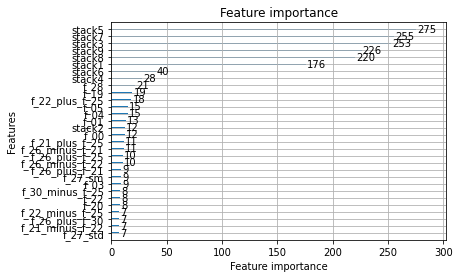

In [75]:
predictions = pd.DataFrame()
for fold in CFG.trn_fold:
    print("="*10, fold, "="*10)
    train_folds = train[train['fold']!=fold]
    valid_folds = train[train['fold']==fold]
    X_train = train_folds[features+['stack1', 'stack2', 'stack3', 'stack4', 'stack5', 'stack6', 'stack7', 'stack8', 'stack9']]
    y_train = train_folds[CFG.label]
    X_valid = valid_folds[features+['stack1', 'stack2', 'stack3', 'stack4', 'stack5', 'stack6', 'stack7', 'stack8', 'stack9']]
    y_valid = valid_folds[CFG.label]
    X_test = test[features+['stack1', 'stack2', 'stack3', 'stack4', 'stack5', 'stack6', 'stack7', 'stack8', 'stack9']]

    model = LGBMClassifier(n_estimators = CFG.n_estimators, learning_rate = 0.1, random_state=0, min_child_samples=90, num_leaves=31, max_bins=511, n_jobs=-1, max_depth=5)
    model.fit(X_train, y_train, eval_metric="auc", eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=30)], verbose=128)
    y_pred = model.predict_proba(X_valid)[:, 1]

    auc = roc_auc_score(y_valid, y_pred)
    print("auc: ", auc)
    train.loc[train['fold']==fold, 'meta'] = y_pred

    y_pred = model.predict_proba(X_test)[:, 1]
    predictions = pd.concat([predictions, pd.DataFrame(y_pred)], axis=1)
    if fold==0:
        lgb.plot_importance(model, max_num_features=30)

sub[CFG.label] = predictions.mean(axis=1)

In [76]:
sub[["id", CFG.label]].to_csv('submission.csv', index=False)

In [77]:
sub.head(10)

,id,target
0,900000,0.998256
1,900001,0.998256
2,900002,0.001660
3,900003,0.001660
4,900004,0.998067
5,900005,0.043568
6,900006,0.392132
7,900007,0.998256
8,900008,0.001813
9,900009,0.998255


memo

* Tabnetの埋め込みの次元を128から変えてみる。<-速度に影響あるかな
* Wandbを見やすくする
https://wandb.ai/site/articles/pytorch-lightning-with-weights-biases
* Ghost Batch Normalization(GBN)を入れてみる
* https://github.com/dreamquark-ai/tabnet/blob/develop/pytorch_tabnet/tab_network.py
* optuna https://qiita.com/studio_haneya/items/2dc3ba9d7cafa36ddffa